# Introduction
The subject we chose to examine in this project is data from the darknet, a specific marketplace that was shut down at 2014 named "Agora".

We had information about sellers and their ratings, items, etc..

We thought it would be interesting to find different correlations between specific data and investigate any pattern or information that stands out.

-> We had issues with scraping the data on the darknet ourselves, thus we use a dataset we've found online and chose to implement our scraping skills for extracting realtime data on Bitcoin and Dollar exchange rates (using APIs).

## Imports

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data cleaning and pre-processing

In [2]:
# load csv + remove spaces from columns
df = pd.read_csv("Agora.csv", engine='python')
df.columns = df.columns.str.replace(' ', '')

# clean Rating column
df = df.drop(df[df['Rating'].isnull()].index)
df['Rating'] = df['Rating'].str.replace('/5', '').replace('[0 deals]', 99).replace(' deals', '').replace('6~10 deals', 99).replace('~1', 1).replace('~2', 2).replace('~3', 3).replace('~4', 4).replace('~5', 5).replace('1~2', 99).replace('1~15', 99).replace('15~25', 99).replace('3~5', 99).replace('6~1', 99).replace('USA', 99).replace('Worldwide', 99).replace('3~5 deals', 99).replace('1~2 deals', 99).replace('~0', '').replace('15~25 deals', 99).replace('10~15 deals', 99).replace('', 99)
df['Rating'] = df['Rating'].astype('float')

df['Rating'] = round(df['Rating'], 0)
df['Rating'] = df['Rating'].astype('int32')

# fill na with unknowns
df['Destination'] = df['Destination'].fillna("Unknown")

# add new column of main category of product
df = pd.concat([df, df['Category'].str.split('/', expand=True)], axis=1)
df = df.rename(columns = {0: 'Main Category', 1: '1',2: '2', 3: '3'})
df = df.drop(columns=['1', '2', '3'])
df['Main Category'] = df['Main Category'].astype(str)

# set types for columns
df['Vendor'] = df['Vendor'].astype(str)
df['Category'] = df['Category'].astype(str)
df['Item'] = df['Item'].astype(str)
df['ItemDescription'] = df['ItemDescription'].astype(str)
df['Origin'] = df['Origin'].astype(str)
df['Destination'] = df['Destination'].astype(str)
df['Remarks'] = df['Remarks'].astype(str)
df = df.drop(df[df['Price'].isnull()].index)

# clean price column
df = df.drop(df[df["Price"].str.contains('BTC') == False].index) # data cleaning - price
df['Price'] = df['Price'].str.replace(' BTC', '')

## Bitcoin converstion to USD via API

In [3]:
# btc to usd
main_url = r"https://www.alphavantage.co/query?function=CURRENCY_EXCHANGE_RATE&from_currency=BTC&to_currency=USD&apikey=R91K0VILGZN3N76I"
response = requests.get(main_url)
soup = BeautifulSoup(response.content, "html.parser")
req_ob = requests.get(main_url) 
result = req_ob.json()
ans =  result["Realtime Currency Exchange Rate"]['5. Exchange Rate']
ans = float(ans)
df['Price'] = df['Price'].astype('float')
df['BTC To USD'] = df['Price'] * ans

In [4]:
# Create the pandas DataFrame
df_vendors = df.groupby('Vendor').size().reset_index(name='Count')

print("Average listings of a vendor: " + str(df_vendors.mean()[0]) + " items.")

df_categories = df.groupby('Category').size().reset_index(name='Count').sort_values(by=['Count'], ascending=False)
df_categories = df_categories.drop(df_categories[df_categories['Count'] < 2].index)

Average listings of a vendor: 34.390718093446225 items.


## 20 Popular categories

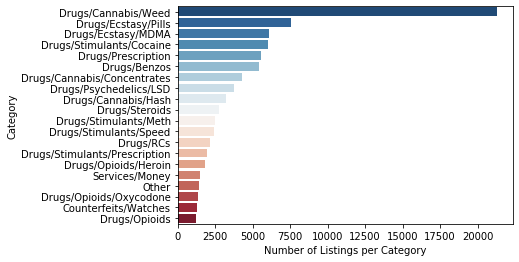

In [5]:
ax = plt.subplot(111)
sns.countplot(y=df.loc[df['Category'].isin(df["Category"].value_counts().index[0:20]), "Category"], order=df["Category"].value_counts().index[:20],palette="RdBu_r",ax=ax)
ax.set_xlabel('Number of Listings per Category')
plt.show()

**We wanted to show the corellation between the categories and number of listings per category**

**We can see that the most listings we had on the marketplace is related to the Drugs category, specifically to the marijuana industry**

**Later we grouped the categories to a more general subjects**

In [6]:
df.describe(include='all')

,Vendor,Category,Item,ItemDescription,Price,Origin,Destination,Rating,Remarks,Main Category,BTC To USD
count,109672,109672,109672,109672,1.096720e+05,109672,109672,109672.000000,109672,109672,1.096720e+05
unique,3189,104,107587,69514,NaN,398,1194,NaN,2,14,NaN
top,optiman,Drugs/Cannabis/Weed,1g MDMA,[----- Terms & Conditions -----] -YOU MUST RE...,NaN,USA,Unknown,NaN,nan,Drugs,NaN
freq,881,21268,18,264,NaN,33729,49151,NaN,97060,93032,NaN
mean,NaN,NaN,NaN,NaN,2.216372e+01,NaN,NaN,12.309696,NaN,NaN,2.042445e+05
std,NaN,NaN,NaN,NaN,1.037713e+03,NaN,NaN,25.248862,NaN,NaN,9.562797e+06
min,NaN,NaN,NaN,NaN,1.000000e-07,NaN,NaN,0.000000,NaN,NaN,9.215260e-04
25%,NaN,NaN,NaN,NaN,1.231046e-01,NaN,NaN,5.000000,NaN,NaN,1.134441e+03
50%,NaN,NaN,NaN,NaN,3.822425e-01,NaN,NaN,5.000000,NaN,NaN,3.522464e+03
75%,NaN,NaN,NaN,NaN,1.329738e+00,NaN,NaN,5.000000,NaN,NaN,1.225388e+04


**We can see that there are only 3000~ vendors that list more than 100k items**

**Most of the vendors located in USA**

## Vendors with most listings

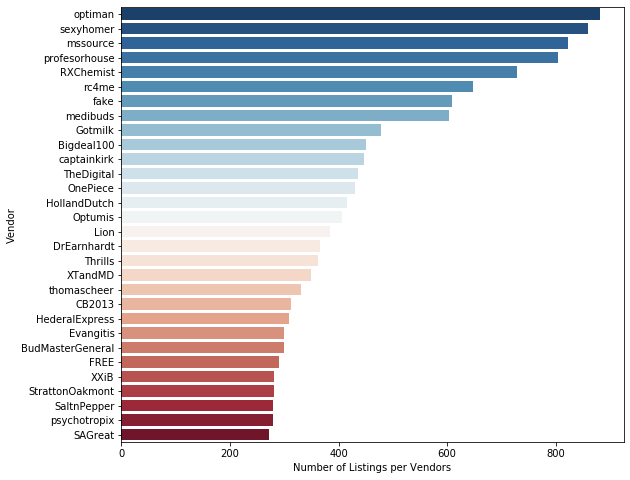

In [7]:
f, ax = plt.subplots(figsize=[9,8])
sns.countplot(y=df.loc[df.Vendor.isin(df["Vendor"].value_counts().index[0:30]),"Vendor"],order=df["Vendor"].value_counts().index[:30],palette="RdBu_r",ax=ax)
ax.set_xlabel('Number of Listings per Vendors')
plt.show()

**We can say that the vendors with the most items for sale use uncommon names with references to: drug names, movies and animes..**

## AVG item name length

In [8]:
df['Item Length'] = df['Item'].apply(len)
print(df['Item Length'].mean())

39.27998030490918


## AVG item description length

In [9]:
df['ItemDesc Length'] = df['ItemDescription'].apply(len)
print('{:0,.2f}'.format(df['ItemDesc Length'].mean()))

174.81


## AVG price item in USD

In [10]:
my_string = '{:0,.0f}'.format(df['BTC To USD'].mean())
print(my_string + "$\n")

204,244$



In [11]:
above = df[df['BTC To USD'] > df['BTC To USD'].mean()].count()[0]
total = len(df.index)
below = total - above

print("Number of items above the median price:")
print(str(above) + "/" + str(total) + " (" + '{:0,.2f}'.format(above/total) + "%)")

print("\nNumber of items below the median price:")
print(str(below) + "/" + str(total) + " (" + '{:0,.2f}'.format(below/total) + "%)")

Number of items above the median price:
1960/109672 (0.02%)

Number of items below the median price:
107712/109672 (0.98%)


**It's interesting to see that most items are ranging between the same price points as we can see above, 98% of the items are being offered below the median price point**

In [12]:
print("Higest price:")
df[df["BTC To USD"] == df["BTC To USD"].max()]

Higest price:


,Vendor,Category,Item,ItemDescription,Price,Origin,Destination,Rating,Remarks,Main Category,BTC To USD,Item Length,ItemDesc Length
22603,HAPPYholland,Drugs/Stimulants/Speed,2g clean pure speed paste in snow seal 14â‚¬ ...,â”€â”€â”€â”€â”€â”€â•”â•—â”€â”€â”€â”€â”€â”€â”€â...,130396.089689,Belgium,Worldwide PRIOR SHIP,5,Average price may be skewed outliar > .5 BTC f...,Drugs,1.201634e+09,63,383


In [13]:
print("Lowest price:")
df[df["BTC To USD"] == df["BTC To USD"].min()]

Lowest price:


,Vendor,Category,Item,ItemDescription,Price,Origin,Destination,Rating,Remarks,Main Category,BTC To USD,Item Length,ItemDesc Length
1335,norman,Services/Money,Trade dirty Bitcoins for brand new ones,Hello Agora Marketplace I'm offering a Bitcoi...,1.000000e-07,nan,Unknown,5,nan,Services,0.000922,39,202
1351,norman,Counterfeits/Money,[1Â¢] Counterfeiting Tutorial + High Quality T...,Hi everyone this is a listing for my Counterf...,1.000000e-07,nan,Unknown,5,nan,Counterfeits,0.000922,54,204
1876,norman,Information/eBooks,[1Â¢] Hacking Wireless Networks For Dummies,Become a cyber-hero - know the common wireless...,1.000000e-07,nan,Unknown,5,nan,Information,0.000922,43,200
1900,norman,Information/eBooks,[1Â¢] The Fine Art of Small Talk: How To Start...,The Fine Art of Small Talk: How To Start a Con...,1.000000e-07,nan,Unknown,5,nan,Information,0.000922,70,196
1950,norman,Information/eBooks,[1Â¢] The Tao of Badass,Hello stranger! This is a listing for the grea...,1.000000e-07,nan,Unknown,5,nan,Information,0.000922,23,202
2044,norman,Information/eBooks,[1Â¢] The Secrets of Great G-Spot Orgasms and ...,Your one-stop shop for G-spot stimulation and ...,1.000000e-07,nan,Unknown,5,nan,Information,0.000922,64,202
2057,norman,Information/eBooks,[1Â¢] How to Win Every Argument: The Use and A...,How to Win Every Argument: The Use and Abuse o...,1.000000e-07,nan,Unknown,5,nan,Information,0.000922,67,192
4801,norman,Forgeries/Scans/Photos,[1Â¢] Fake ID tutorial + HD School ID Scans - ...,Hello everyone! Upon paying the à¸¿0.00001 BTC...,1.000000e-07,World,Unknown,5,nan,Forgeries,0.000922,79,200
13976,Darry,Drugs/Cannabis/Weed,* AFRICA ONLY * 1g MEDICAL GRADE WEED (Sativa)...,Hello I'm new to the market and would like t...,1.000000e-07,Afghanistan,Africa,5,nan,Drugs,0.000922,55,203
38497,0day,Data/Accounts,[x1] 7-day xbox Live Gold code (FREE),I am selling one 7-day xbox live gold trial co...,1.000000e-07,nan,Unknown,5,nan,Data,0.000922,37,142


**We can see that people list different kind of services with the lowest price on the marketplace**

## Is there any other payment method listed on the market?
No! Upon cleaning the Price column, we haven't encountered any cell that does not contains "BTC", meaning that all vendors takes precautions with dealing with payment on the darknet (except of wrong inputs)

## 10 Top origin of the vendors

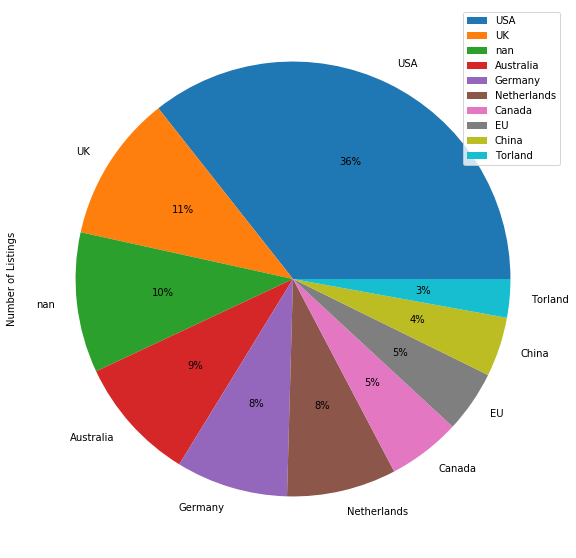

In [14]:
origin_data = df['Origin'].value_counts()[:10]
origin_data = origin_data.to_frame().reset_index()

destination_data = df['Destination'].value_counts()[:10]
destination_data = destination_data.to_frame().reset_index()

origin_data.columns = ['Origin', 'Number of Listings']
plot = origin_data.plot.pie(y='Number of Listings', labels=origin_data['Origin'], autopct='%1.0f%%', figsize=(50, 10))

**We can see that 36% of the vendors located in USA, followed by 11% in the UK and 10% that are not listed..**

## 10 Top vendor's destination countries

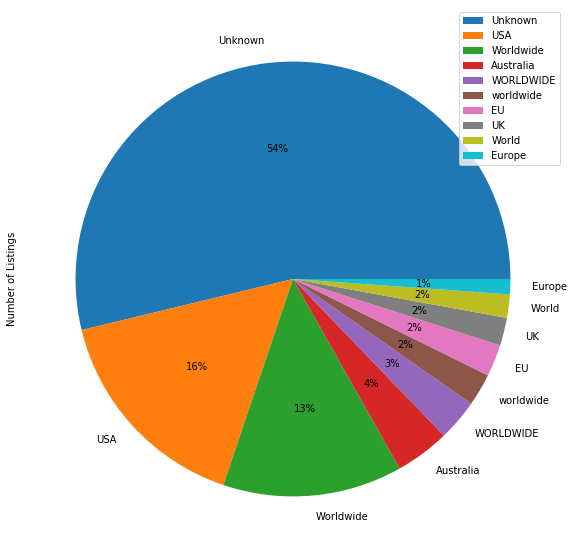

In [15]:
destination_data = df['Destination'].value_counts()[:10]
destination_data = destination_data.to_frame().reset_index()

destination_data.columns = ['Destination', 'Number of Listings']
plot = destination_data.plot.pie(y='Number of Listings', labels=destination_data['Destination'], autopct='%1.0f%%', figsize=(50, 10))

**We can see that 54% of the vendors don't list their prefereed country of audience, maybe because they don't want to minimize their number of customers?**

## Machine learning - KNN

We've chosen to learn & test the median value of the prices (in USD) in the market

In [16]:
X = df.to_numpy()
X = np.delete(X, [0, 1, 2, 3, 5, 6, 8, 9], axis=1)
bitcoin_price = df['BTC To USD'].to_numpy()

y = np.where(bitcoin_price > np.median(bitcoin_price), 1, 0)

In [17]:
print("Minimum BTC price: " + str(np.amin(bitcoin_price)))
print("Meidan BTC price: " + str(np.median(bitcoin_price)))
print("Maximum BTC price: " + str(np.amax(bitcoin_price)))

Minimum BTC price: 0.000921526
Meidan BTC price: 3522.463795911342
Maximum BTC price: 1201633869.468009


In [18]:
df = df.reset_index()

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.5)

clf = KNeighborsClassifier()
parameters = {'n_neighbors':(5, 7, 10, 25, 100, 150)}
clfCV = GridSearchCV(clf, parameters, cv=5)
clfCV.fit(X, y)

_max = np.argmax(clfCV.cv_results_["mean_test_score"])
print("K-neighbors:")
print("Best value {} for permutation {}%".format(clfCV.cv_results_["mean_test_score"][_max], clfCV.cv_results_["params"][_max]))

K-neighbors:
Best value 0.9998267563117894 for permutation {'n_neighbors': 100}%


## Correlation matrix

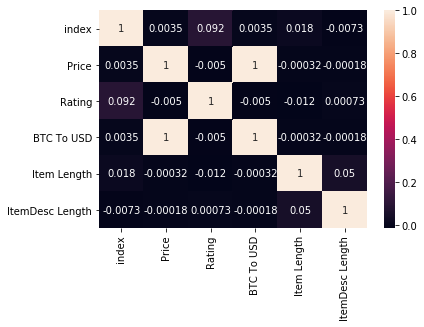

In [20]:
sns.heatmap(df.corr(), annot=True)

## NLTK pre-processing

In [21]:
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.text import Text
import re

from wordcloud import WordCloud, STOPWORDS

## Wordcloud of the listings' description

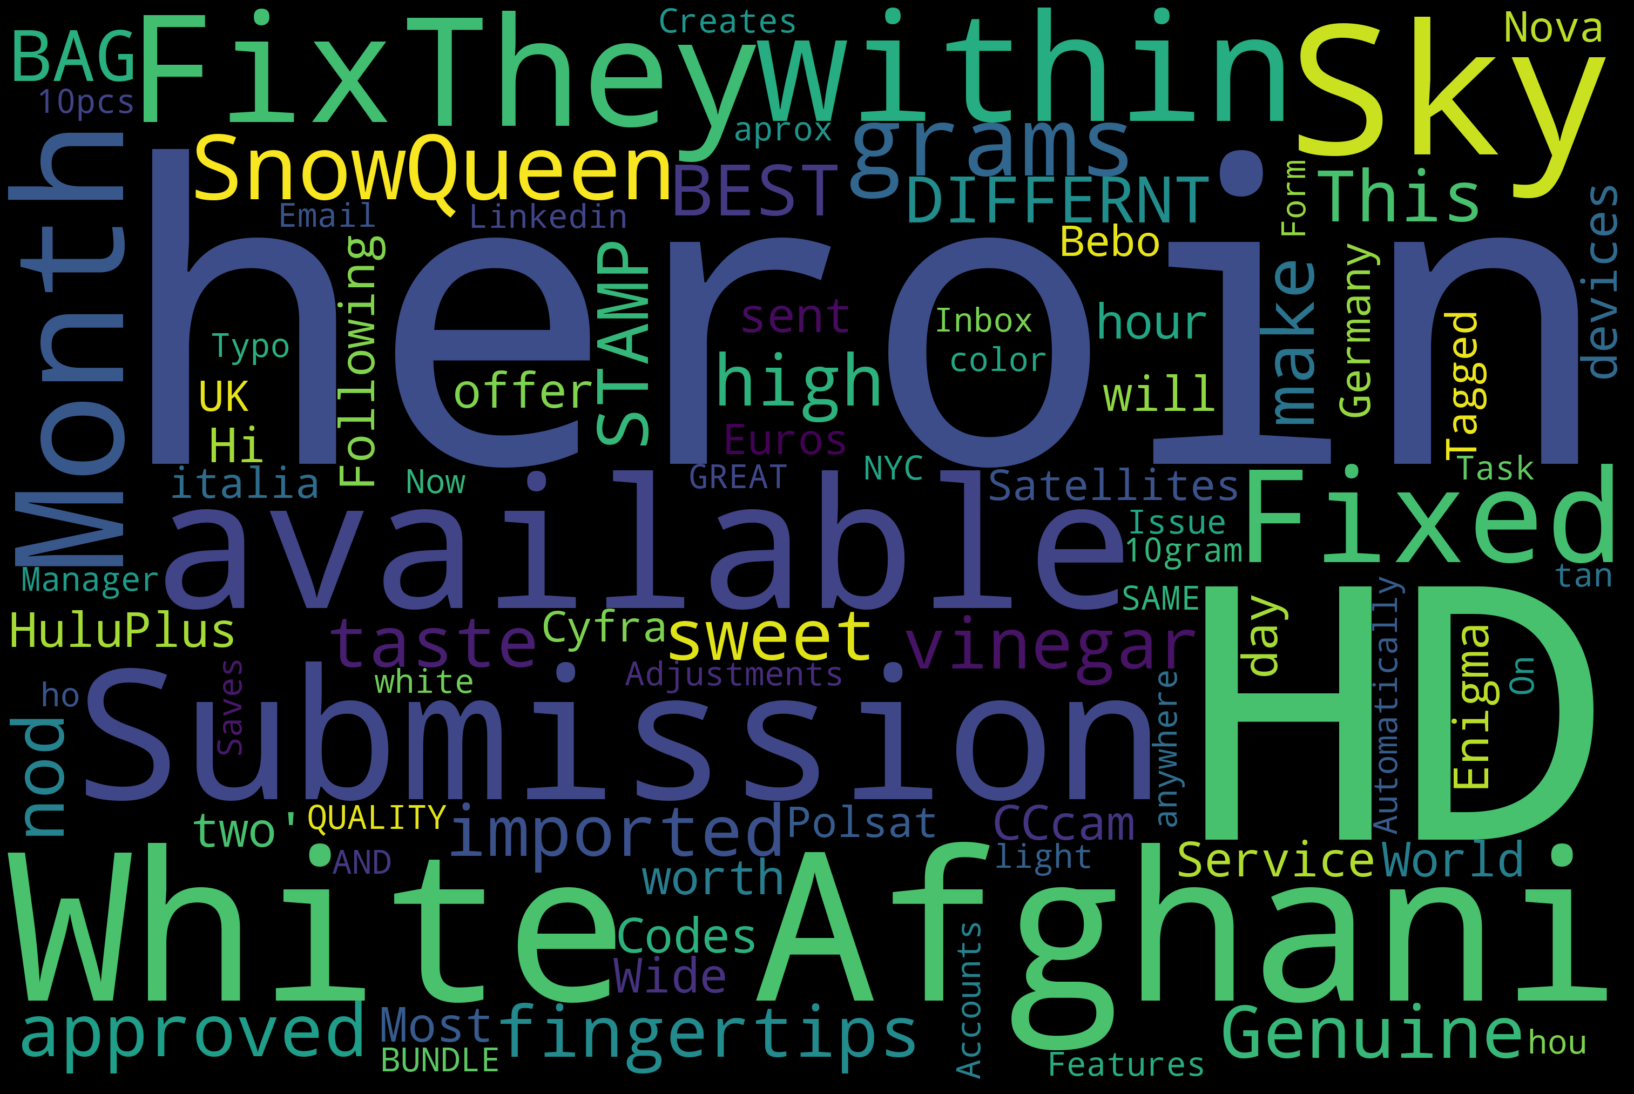

In [22]:
text = df['ItemDescription'].values

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black').generate(str(text))
fig = plt.figure(
    figsize = (40, 15),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Wordcloud of items' listings

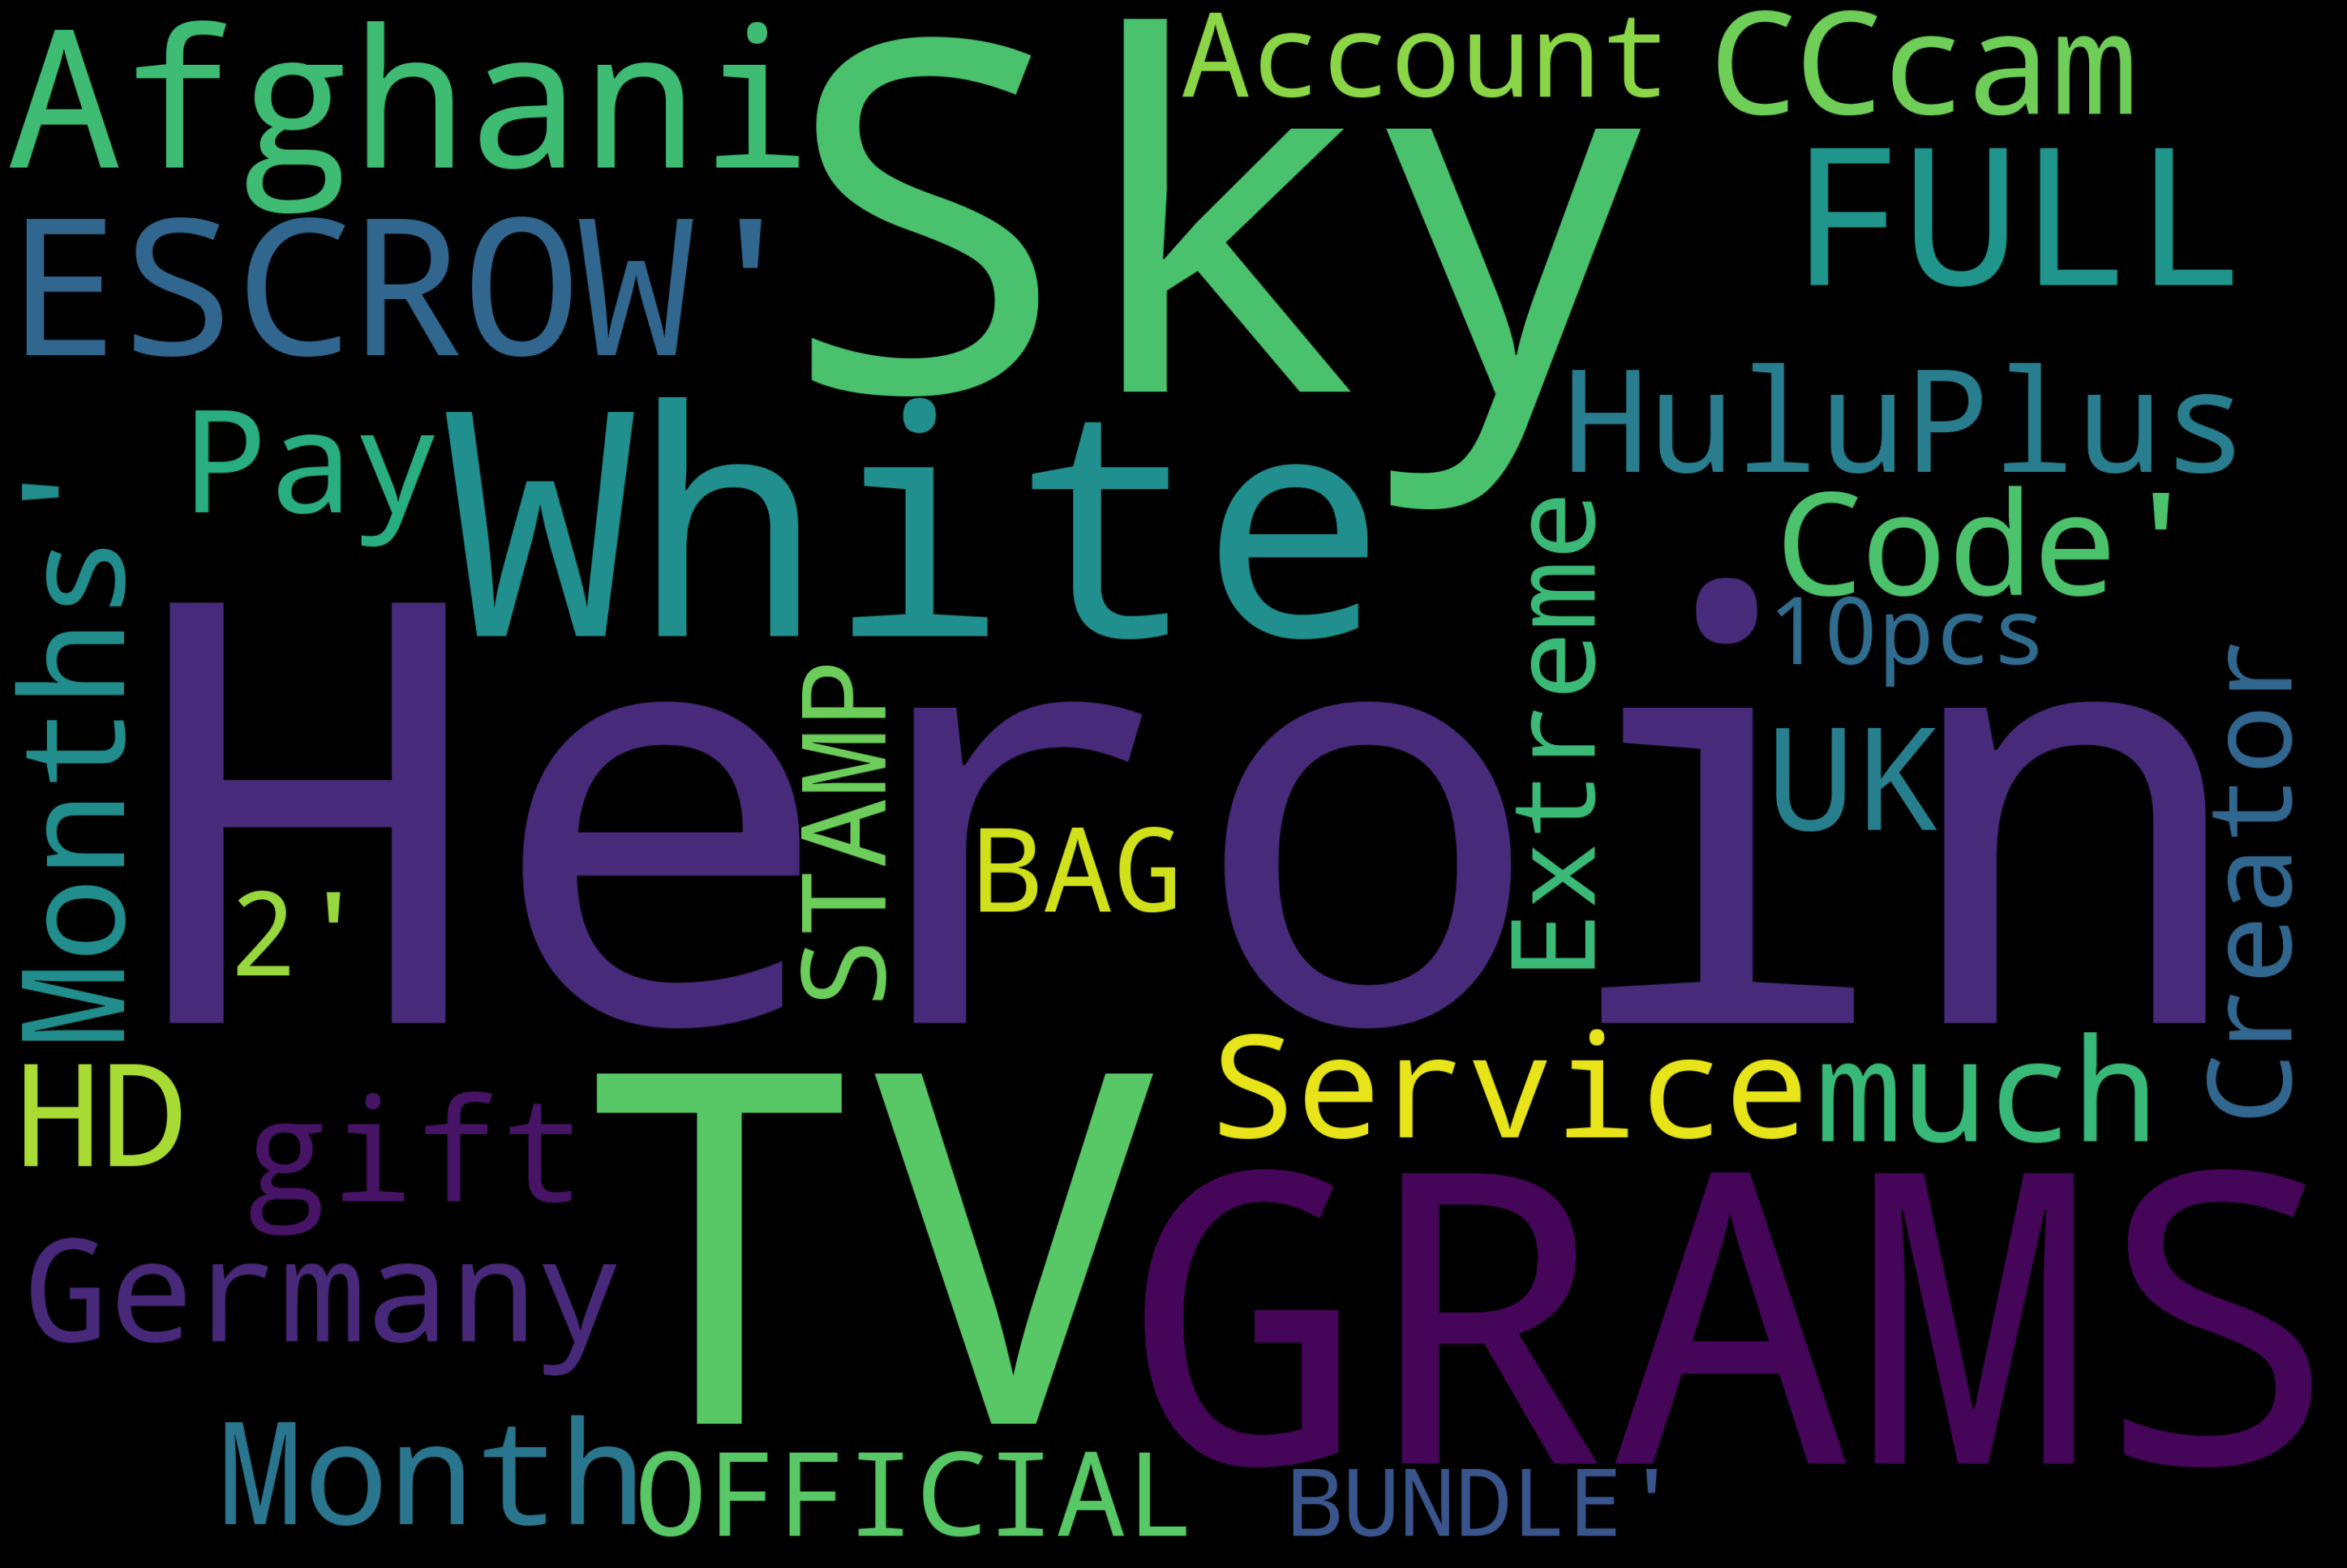

In [23]:
text = df['Item'].values

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black').generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Wordcloud of weapons showcased in the market

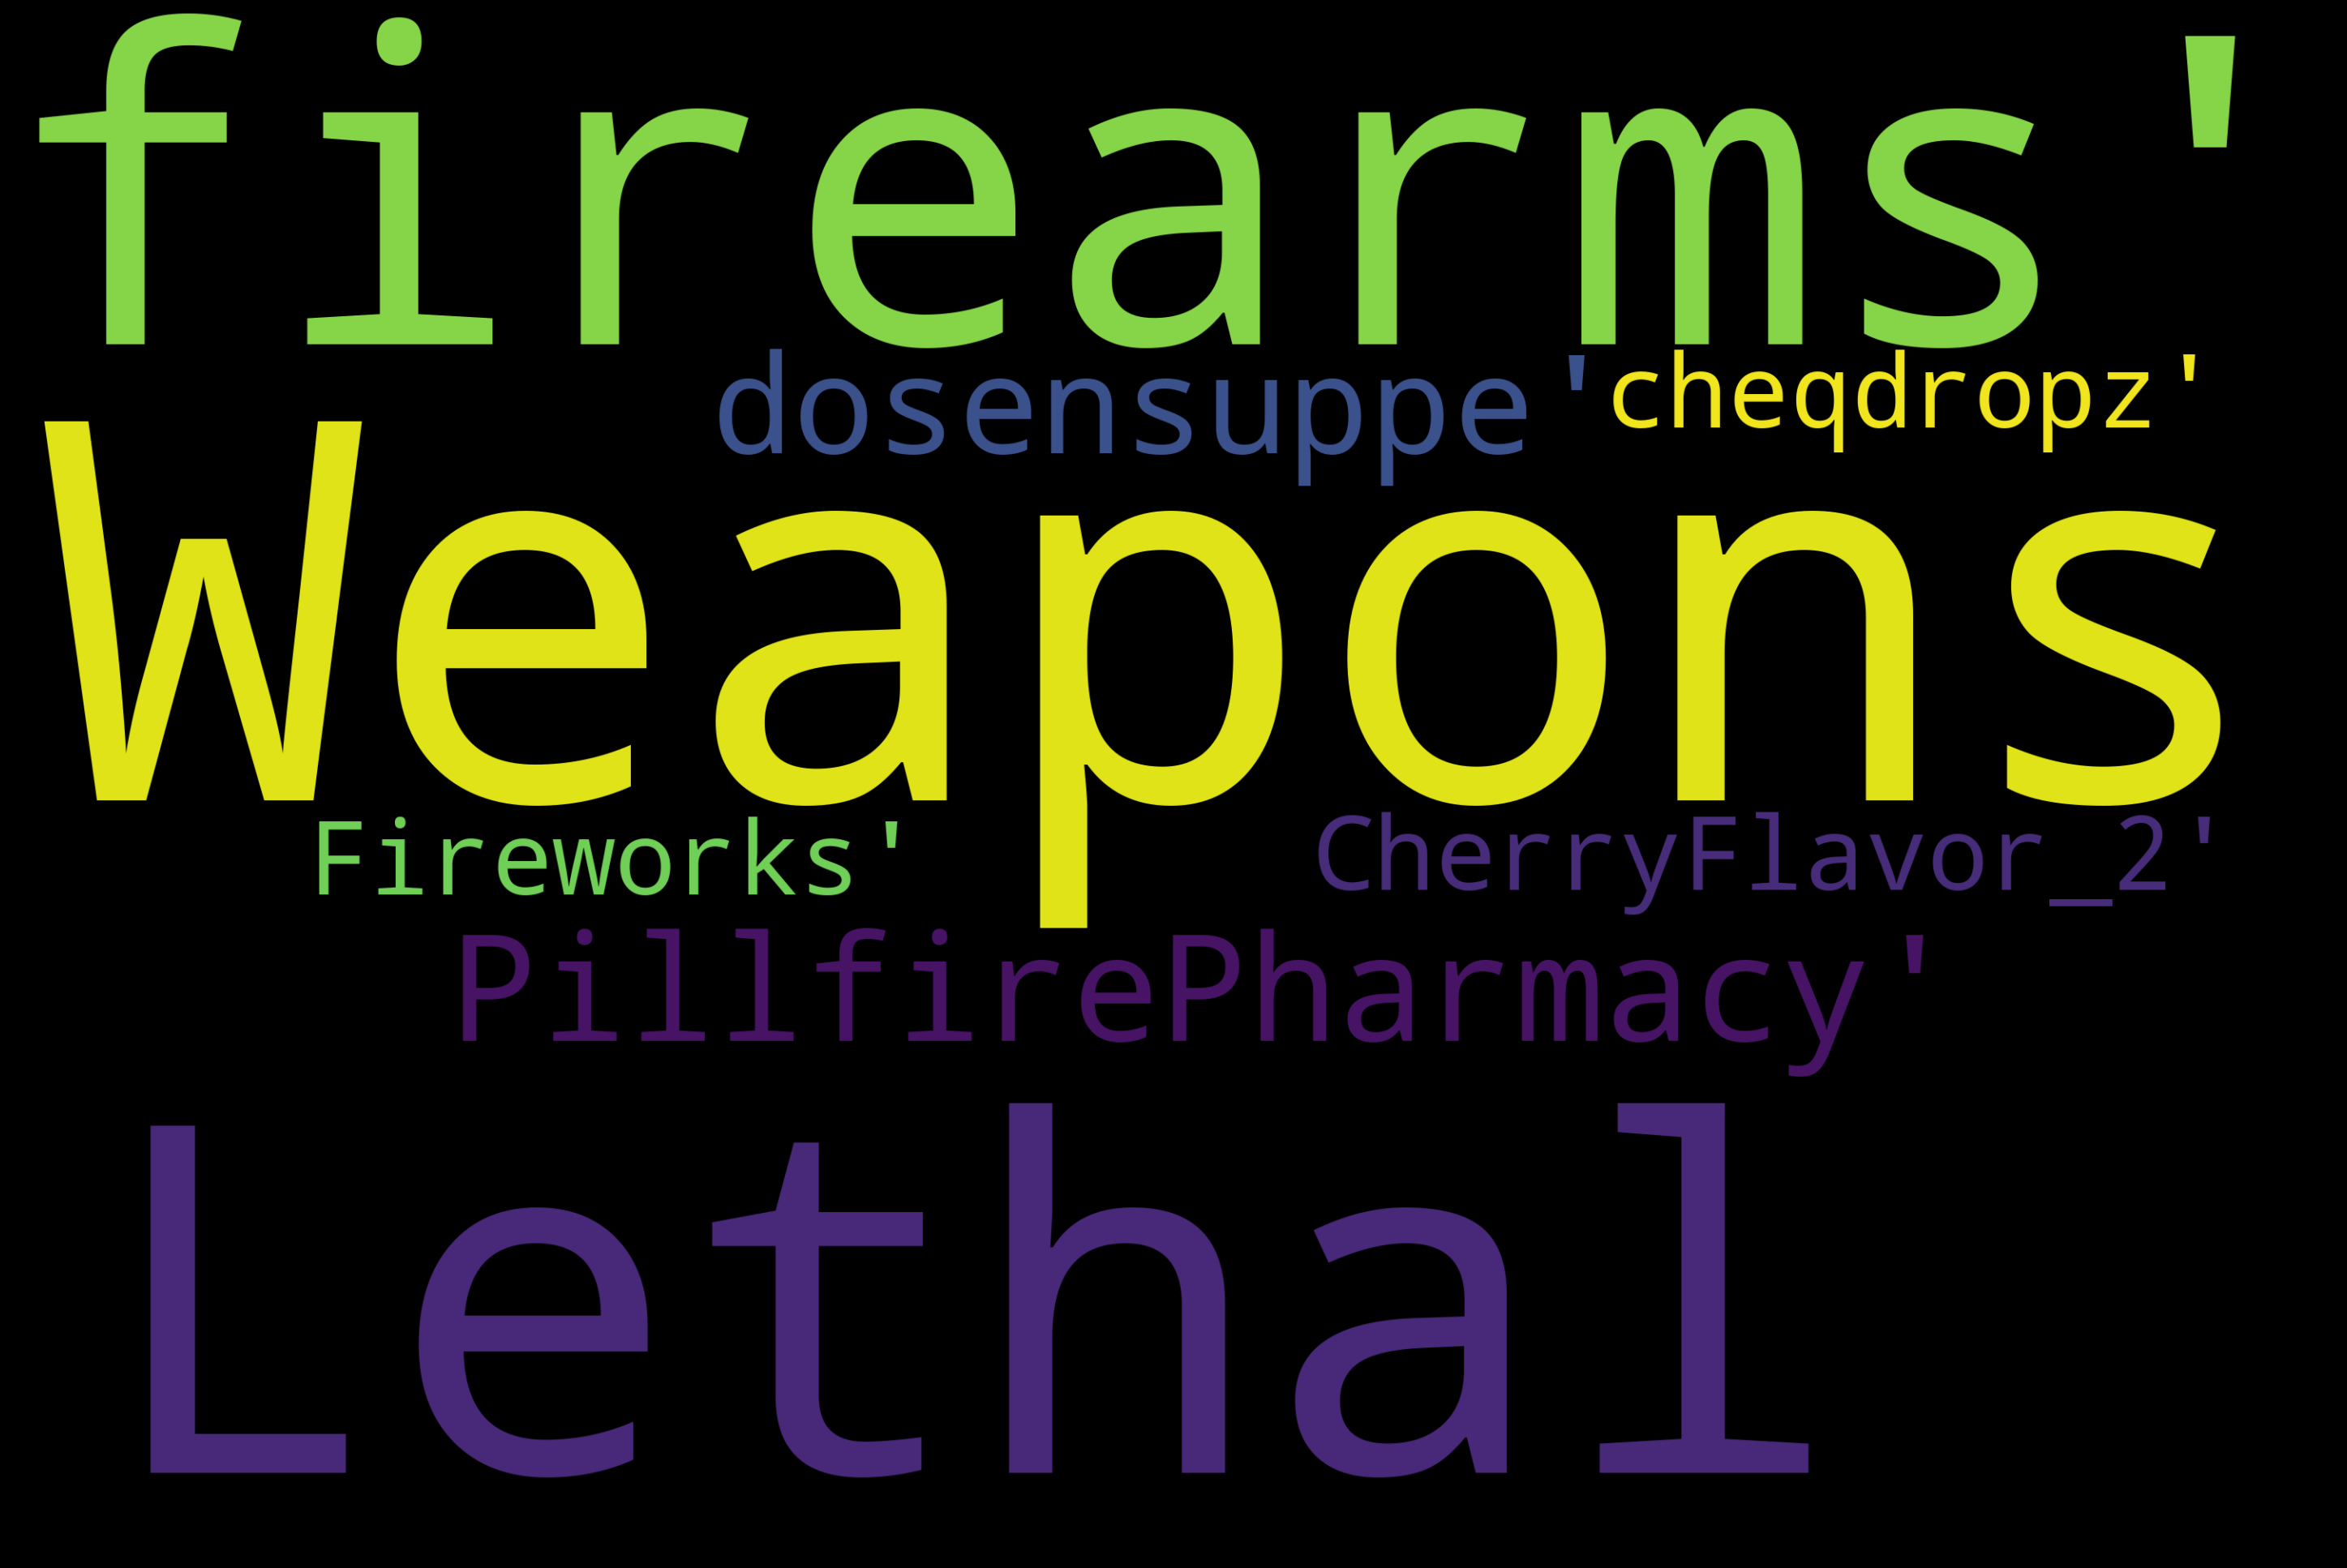

In [24]:
text = df[df['Main Category'] == 'Weapons'].values

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black').generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Word tokens (pre-processing)

In [25]:
df['Item'] = df['Item'].apply(nltk.word_tokenize)
df['ItemDescription'] = df['ItemDescription'].apply(nltk.word_tokenize)

## Examining the different units and odd professions offered in the marketplace

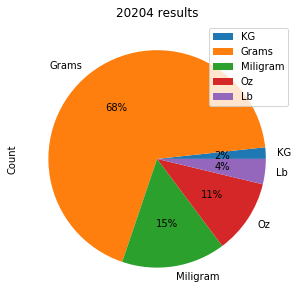

In [26]:
unitList = ['KG', 'Grams', 'Miligram', 'Oz', 'Lb']
unitAmounts = [0, 0, 0, 0, 0]

weirdList = ['Hack', 'Forgery', 'Hitman', 'Murder']
weirdAmounts = [0, 0, 0, 0]

murderIndexList = []

for i in range(len(df['Item'])):
        tokens = [word.lower() for word in df['Item'][i]]
        t = Text(tokens)
        if t.count('kg') or t.count('kilo') or t.count('kilogram') == 1:
            unitAmounts[0] += 1;
        elif t.count('g') or t.count("g's") or t.count('gram') or t.count('grams') == 1:
            unitAmounts[1] += 1
        elif t.count('mg') == 1:
            unitAmounts[2] += 1 
        elif t.count('oz') == 1:
            unitAmounts[3] += 1
        elif t.count('lb') == 1:
            unitAmounts[4] += 1
        
        if t.count('hack') == 1:
            weirdAmounts[0] += 1;
        elif t.count('forger') == 1:
            weirdAmounts[1] += 1
        elif t.count('Hitman') == 1:
            weirdAmounts[2] += 1 
        elif t.count('murder') == 1:
            weirdAmounts[3] += 1
            murderIndexList.append(i)
        
dfConsumption = pd.DataFrame(list(zip(unitList, unitAmounts)), columns =['Unit', 'Count'])
plot = dfConsumption.plot.pie(title=str(sum(unitAmounts)) + " results", y='Count', labels = dfConsumption['Unit'], autopct='%1.0f%%', figsize=(15, 5))

**We can see that 68% out of 20k~ listings are being offered in units of grams, meaning most vendors offer drugs?**

## Examining odd professions inthe marketplace

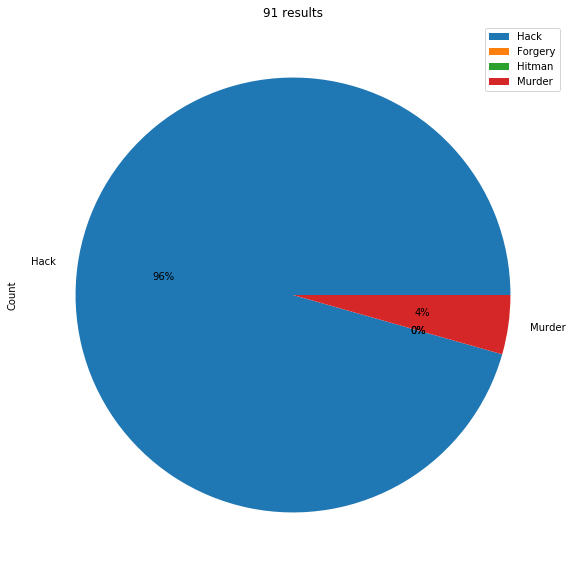

In [27]:
dfProfession = pd.DataFrame(list(zip(weirdList, weirdAmounts)), columns =['Profession', 'Count'])
plot = dfProfession.plot.pie(title= str(sum(weirdAmounts)) + " results", y='Count', labels = dfProfession['Profession'], autopct='%1.0f%%', figsize=(15, 10))

**Out of 91 listings, 96% offer hacking services**

**>> 4 Items are related to murder? what kind of services are there?**

In [28]:
df.iloc[murderIndexList, :]

,index,Vendor,Category,Item,ItemDescription,Price,Origin,Destination,Rating,Remarks,Main Category,BTC To USD,Item Length,ItemDesc Length
1862,1862,Hackyboy,Information/eBooks,"[Murder, guide]","[Hitmen, cleaners, murdererâ€™s, assassins, pr...",0.024899,Torland,Unknown,5,nan,Information,229.448821,12,207
4745,4745,secretsquirrel2,Information/Guides,"[Murder, Inc, How, to, become, an, Assassin]","[Hitmen, cleaners, murdererâ€™s, assassins, pr...",0.004155,Internet,Unknown,5,nan,Information,38.293921,37,207
71717,71731,XXiB,Info/eBooks/Other,"[Jack, The, Rippa, -, Murder, INC, -, The, Boo...","[eBook, Format, :, PDF, We, will, provide, you...",0.021231,Torland,Unknown,5,nan,Info,195.648079,55,202
84650,84664,DrHouse,Information/eBooks,"[Murder, Inc]","[Murder, INC, the, book, by, Jack_the_Rippa, ....",0.020045,Internet,Unknown,5,nan,Information,184.719702,10,51


**Seems like there are actually no murder services, but books describing the topic.. phew**

## Correlation between Category vs Price

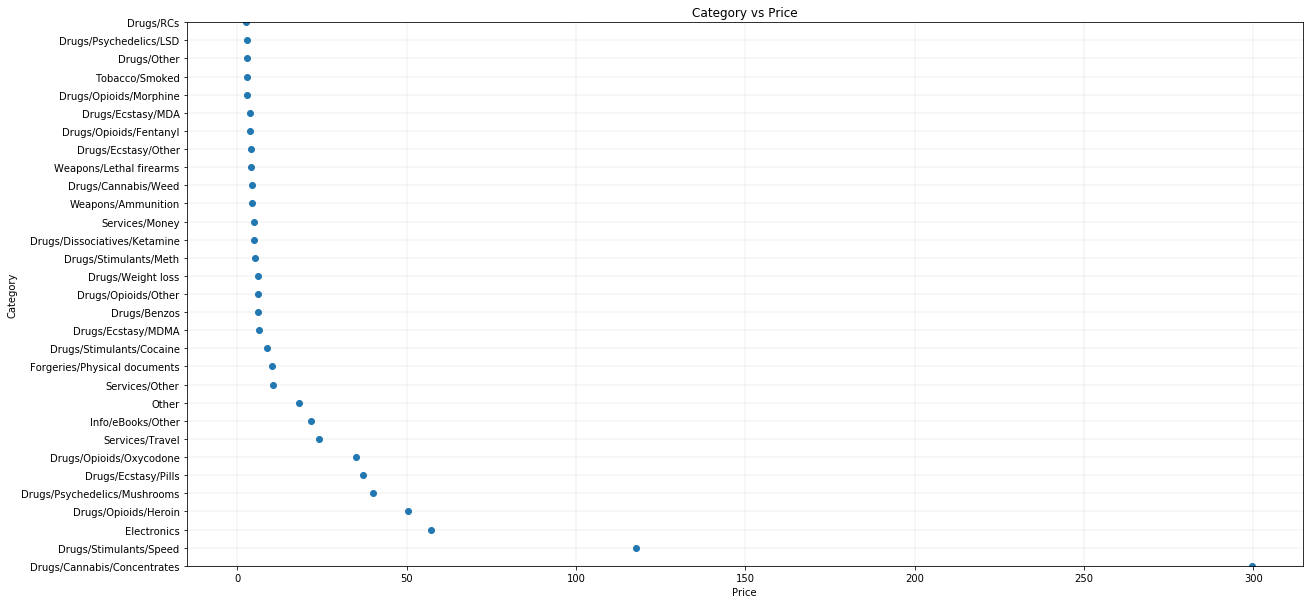

In [29]:
priceCat = df.groupby('Category')['Price'].mean().reset_index(name='Price')
priceCat = priceCat.sort_values(by=['Price'], ascending=False)

def scatterplot(df, x_dim, y_dim, a, b):
  x = df[x_dim]
  y = df[y_dim]
  fig, ax = plt.subplots(figsize=(a, b))
  ax.scatter(x, y)
  ax.set_ylim(0,30)
  ax.set_title('Category vs Price')
  ax.set_xlabel('Price')
  ax.set_ylabel('Category')
  ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
  plt.show()
    
scatterplot(priceCat, 'Price', 'Category', 20, 10)

**We can see the outliers in the graph, but most categories are being priced below 55~ BTC**

## Removing the outliers of Prices

In [30]:
df['Price'] = df['Price'].fillna(df['Price'].median())

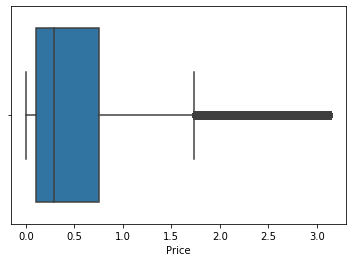

In [31]:
#Finding outliers and replacing them with NaN's
Q1 =  np.percentile(df.Price, 25)
Q3 =  np.percentile(df.Price, 75)
IQR = Q3-Q1

outliers = df[(df.Price< Q1-1.5*IQR) | (df.Price> Q3+1.5*IQR)]

for p in outliers.index:
    df.loc[df.index == p, ['Price']] = np.nan

#Viewing the outliers using boxplot    
price_outliers = sns.boxplot(df.Price)

## Popular rating of an item

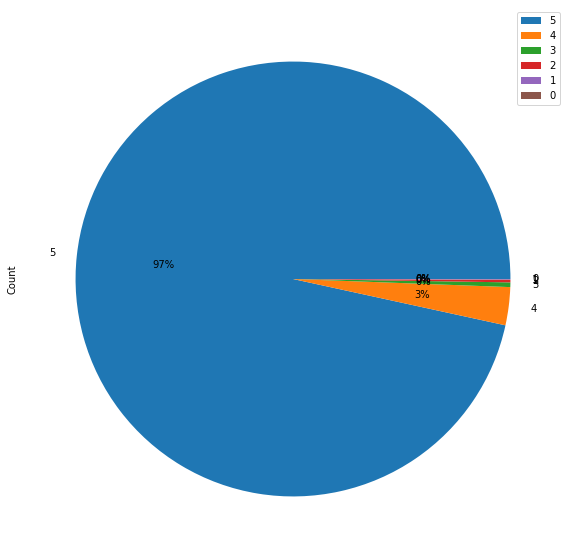

In [32]:
dfRating = df['Rating'].value_counts().reset_index(name='Count')
dfRating = dfRating.drop(dfRating[dfRating['index'] == 99].index) # Ignoring the vendors without any rating
plot = dfRating.plot.pie(y='Count', labels = dfRating['index'], autopct='%1.0f%%', figsize=(20, 10))

**We can see that 97% of the vendors have a rating of 5 (which is the maximum), are they going a great job?**

## Correlation between Global categories vs their Ratings 

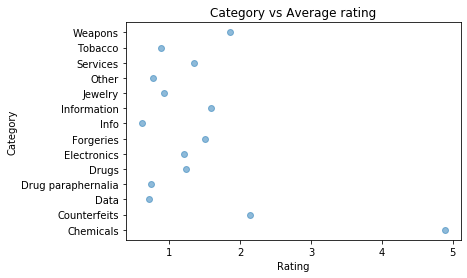

In [33]:
catVsRating = df.groupby('Main Category')['Rating'].mean().reset_index(name='Rating')
catVsRating['Rating'] = round(catVsRating['Rating'], 2)/10

catVsRating
plt.scatter(catVsRating['Rating'], catVsRating['Main Category'], alpha=0.5)
plt.title('Category vs Average rating')
plt.xlabel('Rating')
plt.ylabel('Category')
plt.show()

**We can see that the Chemicals category leads the ratings with a score of 5, whilist the Info category holds the minimum score of <1**

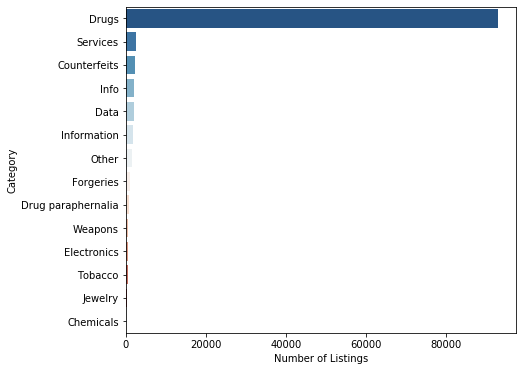

In [34]:
f, ax = plt.subplots(figsize=[7, 6])
sns.countplot(y=df.loc[df['Main Category'].isin(df["Main Category"].value_counts().index), "Main Category"],order=df["Main Category"].value_counts().index,palette="RdBu_r",ax=ax)
ax.set_xlabel('Number of Listings')
ax.set_ylabel('Category')
plt.show()

**We can see that the Drug industry leads the market, with more than 80k listings!!**